In [1]:
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings('ignore')

foods = pd.read_csv('./전국통합식품영양성분정보(가공식품)표준데이터.csv', sep=',', encoding='ms949')

In [2]:
foodSet = pd.DataFrame(foods, columns=['식품코드', '식품명', '대표식품명', '식품대분류명', '식품중분류명', '식품소분류명', '에너지(kcal)', '탄수화물(g)', '단백질(g)', '지방(g)', '포화지방산(g)', '나트륨(mg)'])

In [3]:
# 추가 : '식품대분류명' = '식용유지류', '잼류', '당류', '장류', '조미식품' 배제
# 식사와 직접 관련이 없는 재료류는 제외
#print(foodSet['식품대분류명'])

foodSet = foodSet.loc[(foodSet['식품대분류명'] != '식용유지류') & \
                      (foodSet['식품대분류명'] != '잼류') & \
                      (foodSet['식품대분류명'] != '당류') & \
                      (foodSet['식품대분류명'] != '장류') & \
                      (foodSet['식품대분류명'] != '조미식품')]
len(foodSet)

45196

In [4]:
#temp = foodSet.loc[foodSet['식품대분류명'] == '식용유지류']
#temp = foodSet.loc[foodSet['식품대분류명'] == '면류']
#temp.head()

In [5]:
# 결측치 제거  : NaN 있을 경우 K Mean 측정에서 문제 발생
foodSet.fillna(0, inplace=True)

In [6]:
X = foodSet[['에너지(kcal)', '탄수화물(g)', '단백질(g)', '지방(g)', '포화지방산(g)', '나트륨(mg)']].values

# 에너지(kcal)
X_energy = foodSet[['에너지(kcal)']]
X_energy.head()

,에너지(kcal)
0,43
1,45
2,45
3,54
4,38


In [7]:
#!pip install scikit-learn
#!pip install sklearn.preprocessing

In [8]:
# feature scaling
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))
X_energy = scaler.fit_transform(X_energy)

---

#### **SOM(Self-Organizing Map : 자기 조직화 지도)** <br>

[Link] : https://ko.wikipedia.org/wiki/%EC%9E%90%EA%B8%B0%EC%A1%B0%EC%A7%81%ED%99%94_%EC%A7%80%EB%8F%84<br>
[Link] : https://blog.naver.com/tutumd96/221712405650<br>
[Link] : https://blog.naver.com/plasticcode/221514486602<br>
[Link] : https://thebook.io/080263/0631/

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import font_manager, rc # 폰트 세팅을 위한 모듈 추가
font_path = "malgun.ttf" # 사용할 폰트명 경로 삽입
font = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family = font)

# %matplotlib inline
#sns.pairplot(foodSet, diag_kind = 'kde', hue = 'cluster', palette = 'bright')
#plt.show()

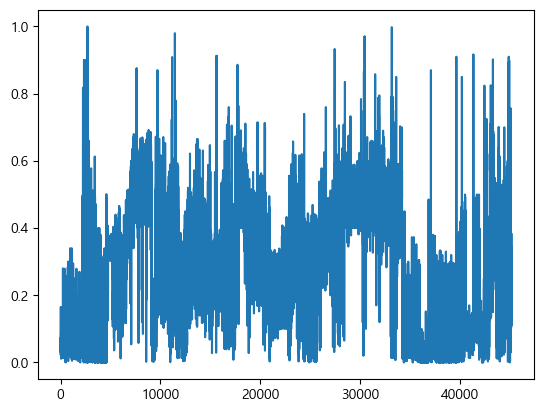

In [10]:
# 에너지(kcal)
plt.plot(X_energy[:])

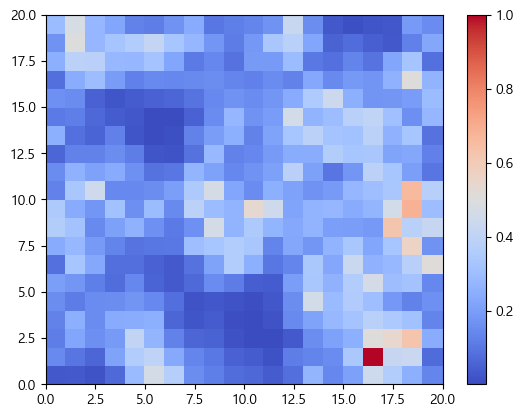

In [11]:
# 자기조직화지도(SOM, Self-Organizing Map)
# : https://hyerimir.tistory.com/194
from minisom import MiniSom
from pylab import plot, axis, show, pcolor, colorbar, bone

# 20 : SOM의 X축에 대한 자원
# 20 : SOM의 Y축에 대한 자원
# 1 : 입력 vector(feature) 수
# sigma : 이웃 노드의 인접 반경
# learning_rate : 한번 학습할 때 얼마큼 변화를 주는지에 대한 상수
foodsSOM1 = MiniSom(20, 20, 1, sigma=1,learning_rate=0.5,topology='hexagonal',neighborhood_function='gaussian',activation_distance='euclidean', random_seed=0)

#초기값설정
foodsSOM1.random_weights_init(X_energy) # 초기화
foodsSOM1.train(X_energy,1000,random_order=True) # 진행

bone()
pcolor(foodsSOM1.distance_map().T, cmap='coolwarm')
colorbar()

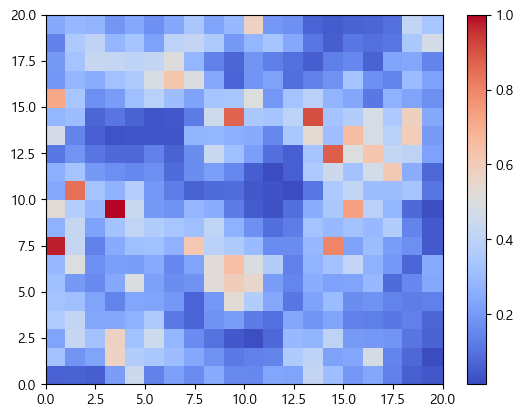

In [12]:
# 탄수화물에 대한 군집 분포

X_carbo = foodSet[['탄수화물(g)']]

scaler = MinMaxScaler(feature_range = (0,1))
X_carbo = scaler.fit_transform(X_carbo)

# 20 : SOM의 X축에 대한 자원
# 20 : SOM의 Y축에 대한 자원
# 1 : 입력 vector(feature) 수
# sigma : 이웃 노드의 인접 반경
# learning_rate : 한번 학습할 때 얼마큼 변화를 주는지에 대한 상수
carboSOM = MiniSom(20, 20, 1, sigma=1,learning_rate=0.5,topology='hexagonal',neighborhood_function='gaussian',activation_distance='euclidean', random_seed=0)

#초기값설정
carboSOM.random_weights_init(X_carbo) # 초기화
carboSOM.train(X_carbo,1000,random_order=True) # 진행

bone()
pcolor(carboSOM.distance_map().T, cmap='coolwarm')
colorbar()

---

In [13]:
#  K Mean(평균) 군집화

#[Link] K-평균(K-Means) 알고리즘 및 KNN(Nearest Neighbor Classifier : K-최근접 이웃)과의 차이점
#: https://velog.io/@jhlee508/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D-K-%ED%8F%89%EA%B7%A0K-Means-%EC%95%8C%EA%B3%A0%EB%A6%AC%EC%A6%98

In [14]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

In [15]:
X_features = foodSet[['에너지(kcal)', '단백질(g)', '지방(g)', '포화지방산(g)', '탄수화물(g)', '나트륨(mg)']].values
X_features

array([[4.300e+01, 4.700e-01, 0.000e+00, 0.000e+00, 1.000e+01, 1.700e+01],
       [4.500e+01, 3.000e-01, 0.000e+00, 0.000e+00, 1.070e+01, 0.000e+00],
       [4.500e+01, 2.000e-01, 2.000e-01, 0.000e+00, 1.100e+01, 0.000e+00],
       ...,
       [1.970e+02, 1.543e+01, 1.153e+01, 3.680e+00, 7.920e+00, 7.780e+02],
       [1.210e+02, 2.357e+01, 1.430e+00, 5.000e-01, 3.570e+00, 2.570e+02],
       [2.000e+02, 2.200e+01, 1.100e+01, 3.800e+00, 4.000e+00, 3.030e+02]])

In [16]:
# 정규 분포로 다시 스케일링하기
from sklearn.preprocessing import StandardScaler

X_features_scaled = StandardScaler().fit_transform(X_features)
X_features_scaled

array([[-1.35555531, -0.78734614, -0.8306632 , -0.69376216, -1.21440806,
        -0.53765741],
       [-1.34430497, -0.81424597, -0.8306632 , -0.69376216, -1.18852761,
        -0.58759902],
       [-1.34430497, -0.83006941, -0.8143104 , -0.69376216, -1.17743599,
        -0.58759902],
       ...,
       [-0.48927914,  1.57983954,  0.11207577, -0.14402437, -1.29130999,
         1.69796393],
       [-0.91679205,  2.86786704, -0.71374068, -0.61906952, -1.45213853,
         0.16740057],
       [-0.47240363,  2.61943914,  0.06874085, -0.12609814, -1.43624053,
         0.30253668]])

In [17]:
# 참고) 엘보 메소드(방법 : elbow method)
#: Cluster 간의 거리의 합을 나타내는 inertia가 급격히 떨어지는<b>(꺾이는 = 엘보(elbow)) 구간</b>이 생기는데, 이 지점의 K 값을 군집의 개수로 사용<br>
#
# [Link] : https://steadiness-193.tistory.com/285

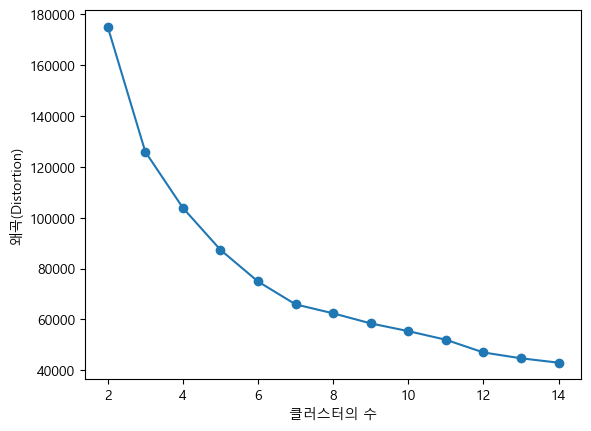

In [18]:
# 최적의 k 찾기 (1) 엘보우 방법
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc # 폰트 세팅을 위한 모듈 추가

font_path = "malgun.ttf" # 사용할 폰트명 경로 삽입
font = font_manager.FontProperties(fname = font_path).get_name()
rc('font', family = font)

distortions = [] # 왜곡

for i in range(2, 15):
    kmeans_i = KMeans(n_clusters=i, random_state=0)  # 모델 생성
    kmeans_i.fit(X_features_scaled)   # 모델 훈련
    distortions.append(kmeans_i.inertia_)
    
plt.plot(range(2, 15), distortions, marker='o')
plt.xlabel('클러스터의 수')
plt.ylabel('왜곡(Distortion)')
plt.show()

---

In [19]:
# 최종 군집화 결과맵-2 : detail
# 최적의 k 찾기 (2) 실루엣 계수에 따른 각 클러스터의 비중 시각화 함수 정의

from matplotlib import cm

def silhouetteViz(n_cluster, X_features): 
    
    kmeans = KMeans(n_clusters=n_cluster, random_state=0)
    Y_labels = kmeans.fit_predict(X_features)
    
    silhouette_values = silhouette_samples(X_features, Y_labels, metric='euclidean')

    y_ax_lower, y_ax_upper = 0, 0
    y_ticks = []

    for c in range(n_cluster):
        c_silhouettes = silhouette_values[Y_labels == c]
        c_silhouettes.sort()
        y_ax_upper += len(c_silhouettes)
        color = cm.jet(float(c) / n_cluster)
        plt.barh(range(y_ax_lower, y_ax_upper), c_silhouettes,
                 height=1.0, edgecolor='none', color=color)
        y_ticks.append((y_ax_lower + y_ax_upper) / 2.)
        y_ax_lower += len(c_silhouettes)
    
    silhouette_avg = np.mean(silhouette_values)
    plt.axvline(silhouette_avg, color='red', linestyle='--')
    plt.title('Number of Cluster : '+ str(n_cluster)+'\n' \
              + 'Silhouette Score : '+ str(round(silhouette_avg,3)))
    plt.yticks(y_ticks, range(n_cluster))   
    plt.xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.ylabel('Cluster')
    plt.xlabel('Silhouette coefficient')
    plt.tight_layout()
    plt.show()

In [20]:
# 클러스터 수에 따른 클러스터 데이터 분포의 시각화 함수 정의
def clusterScatter(n_cluster, X_features): 
    c_colors = []
    kmeans = KMeans(n_clusters=n_cluster, random_state=0)
    Y_labels = kmeans.fit_predict(X_features)

    for i in range(n_cluster):
        c_color = cm.jet(float(i) / n_cluster) #클러스터의 색상 설정
        c_colors.append(c_color)
        #클러스터의 데이터 분포를 동그라미로 시각화
        plt.scatter(X_features[Y_labels == i,0], X_features[Y_labels == i,1],
                     marker='o', color=c_color, edgecolor='black', s=50, 
                     label='cluster '+ str(i))       
    
    #각 클러스터의 중심점을 삼각형으로 표시
    for i in range(n_cluster):
        plt.scatter(kmeans.cluster_centers_[i,0], kmeans.cluster_centers_[i,1], 
                    marker='^', color=c_colors[i], edgecolor='w', s=200)
        
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

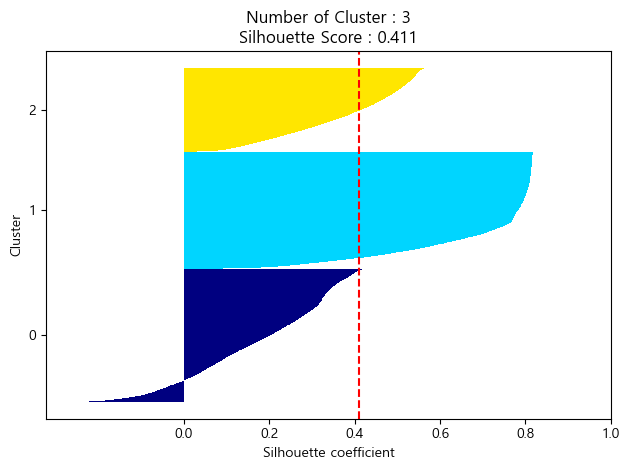

In [21]:
silhouetteViz(3, X_features_scaled) #클러스터 3개인 경우의 실루엣 score 및 각 클러스터 비중 시각화  ex) 0.411

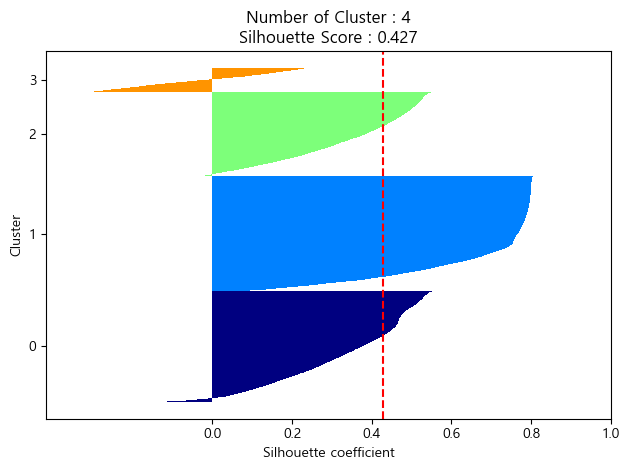

In [22]:
silhouetteViz(4, X_features_scaled) #클러스터 4개인 경우의 실루엣 score 및 각 클러스터 비중 시각화  ex) 0.427

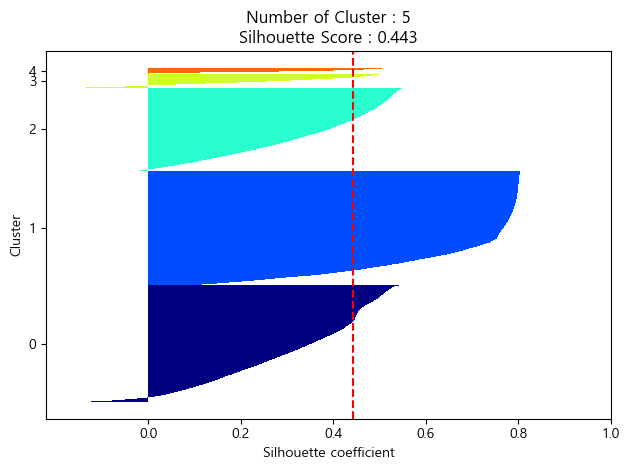

In [23]:
silhouetteViz(5, X_features_scaled) #클러스터 5개인 경우의 실루엣 score 및 각 클러스터 비중 시각화  ex) 0.443

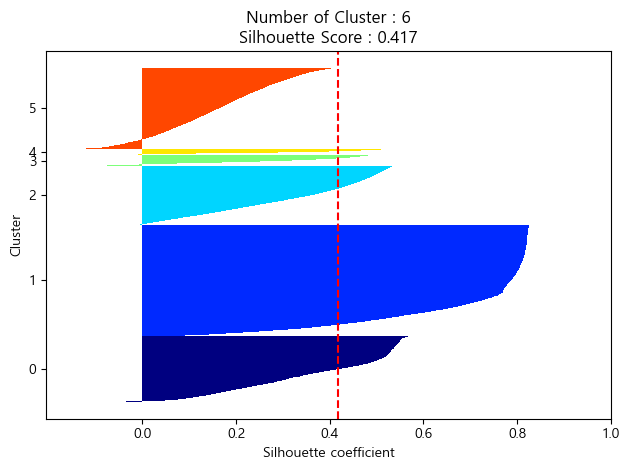

In [24]:
silhouetteViz(6, X_features_scaled) #클러스터 6개인 경우의 실루엣 score 및 각 클러스터 비중 시각화  ex) 0.417

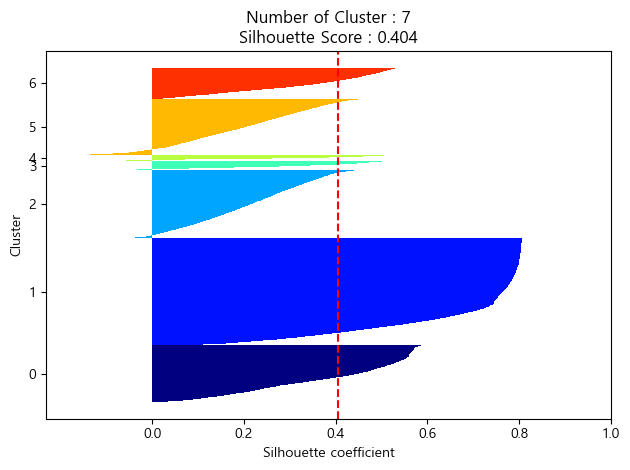

In [25]:
silhouetteViz(7, X_features_scaled) #클러스터 7개인 경우의 실루엣 score 및 각 클러스터 비중 시각화  ex) 0.404

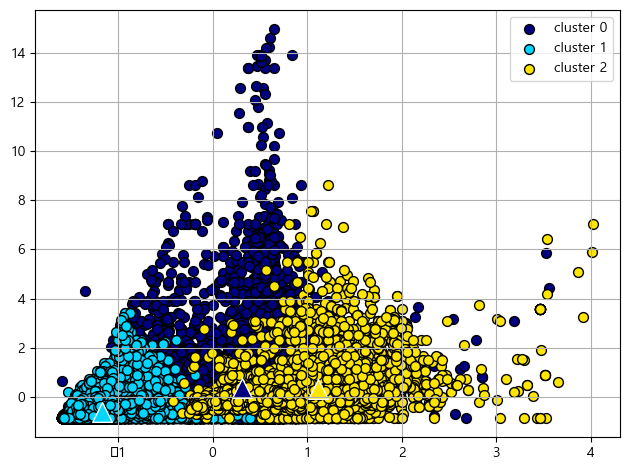

In [26]:
clusterScatter(3, X_features_scaled) #클러스터 3개인 경우의 클러스터 데이터 분포 시각화

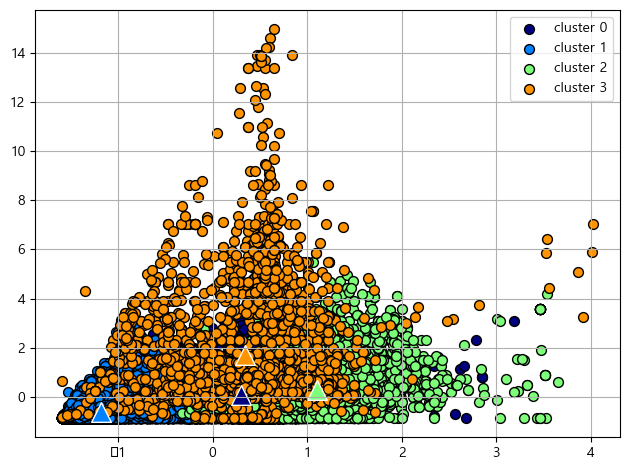

In [27]:
clusterScatter(4, X_features_scaled)  #클러스터 4개인 경우의 클러스터 데이터 분포 시각화

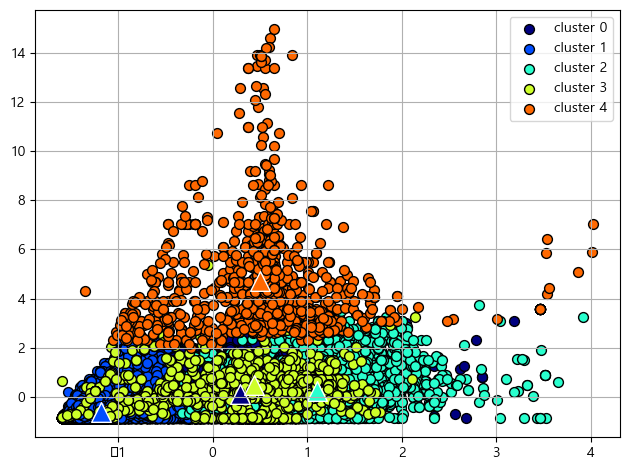

In [28]:
clusterScatter(5, X_features_scaled)  #클러스터 5개인 경우의 클러스터 데이터 분포 시각화

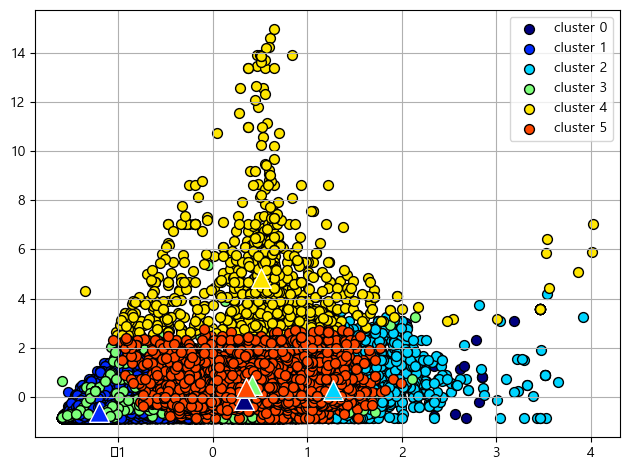

In [29]:
clusterScatter(6, X_features_scaled)  #클러스터 6개인 경우의 클러스터 데이터 분포 시각화

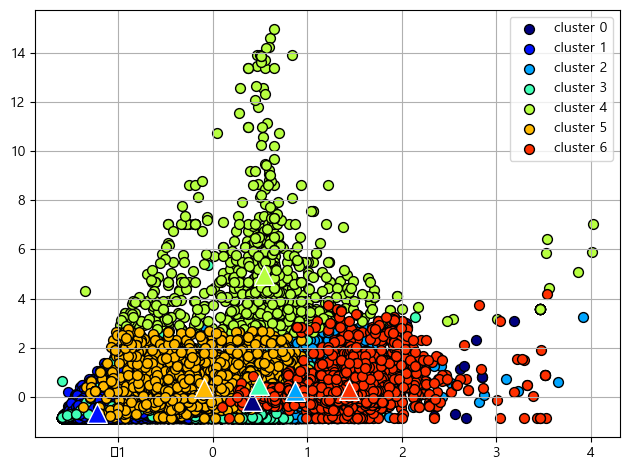

In [30]:
clusterScatter(7, X_features_scaled)  #클러스터 7개인 경우의 클러스터 데이터 분포 시각화

#### 변경)  논문과 달리 최적의 K 값은 **5**로 판정됨  ex) 0.443

---

In [31]:
best_cluster = 5 # 변경

# 최적화 클러스터의 개수를  5에 맞추어 K-Mean 군집화 모델을 다시 생성
kmeans = KMeans(n_clusters=best_cluster, random_state=0) 
# 모델 학습과 결과 예측(클러스터 레이블생성)
Y_labels = kmeans.fit_predict(X_features_scaled)

foodSet['clusterLabel'] = Y_labels
foodSet.head()

,식품코드,식품명,대표식품명,식품대분류명,식품중분류명,식품소분류명,에너지(kcal),탄수화물(g),단백질(g),지방(g),포화지방산(g),나트륨(mg),clusterLabel
0,P109-302030200-2176,과·채주스_프룻밀토마토,과·채주스,음료류,과일·채소류음료,과·채주스,43,10.0,0.47,0.00,0.00,17.0,1
1,P109-302030200-2177,과·채주스_프리마5후르츠칵테일주스,과·채주스,음료류,과일·채소류음료,과·채주스,45,10.7,0.30,0.00,0.00,0.0,1
2,P109-302030200-2178,과·채주스_프리마셀렉션사과주스,과·채주스,음료류,과일·채소류음료,과·채주스,45,11.0,0.20,0.20,0.00,0.0,1
3,P109-302030200-2179,과·채주스_프리마셀렉션파인애플주스,과·채주스,음료류,과일·채소류음료,과·채주스,54,12.5,0.50,0.20,0.00,0.0,1
4,P109-302030200-2180,과·채주스_프리미엄 애플망고주스,과·채주스,음료류,과일·채소류음료,과·채주스,38,8.0,0.19,0.56,0.03,1.0,1


In [32]:
foodSet.to_csv('./Final_Cluster_Result.csv')

In [33]:
# ex) '떡갈비' 영양소 벡터
pd.set_option('display.max_seq_items', None) # 생략없이 전부 출력

ex_product = foods.loc[foods['식품명'].str.contains('떡갈비')]
ex_product.head(1)

,식품코드,식품명,데이터구분코드,데이터구분명,식품기원코드,식품기원명,식품대분류코드,식품대분류명,대표식품코드,대표식품명,...,유통업체명,수입여부,원산지국코드,원산지국명,데이터생성방법코드,데이터생성방법명,데이터생성일자,데이터기준일자,제공기관코드,제공기관명
14113,P106-001000300-0011,두부_두부적 네모 떡갈비,P,가공식품,1,가공식품,6,두부류 또는 묵류,6001,두부,...,㈜푸드머스,N,36.0,해당없음,2,수집,2022-12-29,2024-02-23,1471000,식품의약품안전처


In [34]:
X_features_scaled[14113]

array([-0.27552268,  0.08768975, -0.63442959, -0.69376216,  0.15355884,
       -0.20569261])

In [35]:
# 최종 결과에 따른 군집 분포

# 20 : SOM의 X축에 대한 자원
# 20 : SOM의 Y축에 대한 자원
# 6 : 입력 vector(feature) 수
# sigma : 이웃 노드의 인접 반경
# learning_rate : 한번 학습할 때 얼마큼 변화를 주는지에 대한 상수
finalFoodsSOM = MiniSom(20, 20, 6, sigma=1,learning_rate=0.5,topology='hexagonal',neighborhood_function='gaussian',activation_distance='euclidean', random_seed=0)

#초기값설정
finalFoodsSOM.random_weights_init(X_features_scaled) # 초기화
finalFoodsSOM.train(X_features_scaled,1000,random_order=True) # 진행

#bone()
#pcolor(finalFoodsSOM.distance_map().T, cmap='coolwarm')
#colorbar()

---

In [36]:
# 추가 분석 : 각 클러스터 파악
# 'clusterLabel' 기준으로 그룹을 만듦 => 5개의 클러스터(군집)으로 구성됨
foodSet.groupby('clusterLabel')['식품명'].count()

clusterLabel
0    15782
1    15447
2    11276
3     1769
4      922
Name: 식품명, dtype: int64

In [37]:
from sklearn.metrics.pairwise import cosine_similarity 
# 주의) 사이킷런의 유사도 인자는 2차원 배열로 코사인 인자를 받으므로 변환이 필요함

inputFood = foodSet.loc[foodSet['식품명'].str.contains('오렌지주스')].iloc[0] # clusterLabel = 1
inputFood 

식품코드            P109-302030200-2068
식품명             과·채주스_파스퇴르발렌시아오렌지주스
대표식품명                         과·채주스
식품대분류명                          음료류
식품중분류명                     과일·채소류음료
식품소분류명                        과·채주스
에너지(kcal)                        43
탄수화물(g)                        10.0
단백질(g)                          0.4
지방(g)                           0.1
포화지방산(g)                       0.05
나트륨(mg)                        10.0
clusterLabel                      1
Name: 130, dtype: object

In [38]:
inputFood.index

Index(['식품코드', '식품명', '대표식품명', '식품대분류명', '식품중분류명', '식품소분류명', '에너지(kcal)',
       '탄수화물(g)', '단백질(g)', '지방(g)', '포화지방산(g)', '나트륨(mg)', 'clusterLabel'],
      dtype='object')

In [39]:
# "clusterLabel = 1"인 군집 내에서 유사도 분석
foodIdx = foodSet[foodSet['clusterLabel'] == 1].index
#foodName = foodSet[foodSet['clusterLabel'] == 1]['식품명']
#foodName

# "과·채주스_파스퇴르발렌시아오렌지주스" 제품의 index
foodSet[foodSet['식품명'] == '과·채주스_파스퇴르발렌시아오렌지주스'].index[0] # index = 130

130

In [40]:
# 특정 index의 상품 정보
foodSet.iloc[130]
targetIdx = foodSet[foodSet['식품명'] == '과·채주스_파스퇴르발렌시아오렌지주스'].index[0]
targetIdx

130

---

In [41]:
# 군집 내의 유사도 측정
# targetIdx : "과·채주스_파스퇴르발렌시아오렌지주스"의 index

from numpy import dot
from numpy.linalg import norm

# lialg(Linear Algebra : 선형대수 함수) 라이브러리
# norm : 벡터의 크기(magnitude) 또는 길이(length)를 측정하는 방법. 
# 벡터 공간을 어떤 양의 실수 값으로 매핑하는 함수와 유사함.
# norm : https://numpy.org/doc/stable/reference/generated/numpy.linalg.norm.html

# 코사인 유사도(cosine similarity) 측정 함수
def get_cosine_similarity(m1, m2):
    return dot(m1, m2)/(norm(m1)*norm(m2))

similarValues = []

# ValueError: Expected 2D array, got 1D array instead:
# 상기 에러 패치위한 조치 : array.reshape 함수 활용
# 주의) 사이킷런의 코사인 유사도 인자는 2차원 배열로 인자를 받으므로 변환이 필요함

#print("타겟 index : ",  X_features_scaled[targetIdx].reshape(-1, 1))
#print("다른 index : ", X_features_scaled[1].reshape(-1, 1))

#cosine_similarity(X_features_scaled[targetIdx].reshape(-1, 1), X_features_scaled[idx].reshape(-1, 1))

cosSimilDict = {} # index(key), 코사인 유사도(value)

# 최대의 유사도를 지난 식품은 타겟 식품 자신이므로, 이를 제외하고 검색 
for idx in foodIdx:
    # print(idx)
    # simil_val = cosine_similarity(X_features_scaled[targetIdx].reshape(-1, 1), X_features_scaled[idx].reshape(-1, 1))

    if (idx < len(foodSet)):
        similVal = get_cosine_similarity(X_features_scaled[targetIdx], X_features_scaled[idx])
        #similarValues.append(similVal)

        # 타겟 상품 제외
        if (idx != targetIdx):
            cosSimilDict[idx] = similVal
    else:        
        break;
    
    #print(similVal)

print(cosSimilDict)

minCosSimilVal = min(cosSimilDict.values())

# 최대 유사도 선정시 후보군 선정 유사도 0.99 이상인 제품군 생성
maxNearCosSimilVals = [val for val in cosSimilDict.values() if val > 0.99]

print('최저 유사도(가장 관계가 적은 식품) : ', minCosSimilVal) # 가장 유사도가 낮은 값  ex) -0.012988934902584414
#print('최근접 유사도 후보군(0.99 이상) : ', maxNearCosSimilVals)

{0: 0.9999392719009399, 1: 0.9998123466635945, 2: 0.9996829341799901, 3: 0.9993390603519349, 4: 0.9994870792540296, 5: 0.9990342768389985, 6: 0.9993656530401898, 7: 0.9979004900687979, 8: 0.9936257571710093, 9: 0.9991945215126757, 10: 0.995181995877009, 11: 0.9977273543181064, 12: 0.9977273543181064, 13: 0.9964991679799883, 14: 0.9991193696750131, 15: 0.9798300886611995, 16: 0.9934004063641879, 17: 0.8634385160768259, 18: 0.995181995877009, 19: 0.9980799818658072, 20: 0.9996744070864324, 21: 0.9994110234022126, 22: 0.9993676006463661, 23: 0.9988325980349664, 24: 0.9997758589520014, 25: 0.9974455799912637, 26: 0.999625689564462, 27: 0.9999593871795981, 28: 0.9990109449233764, 29: 0.9984876137277422, 30: 0.9990719676260228, 31: 0.999756582403925, 32: 0.9986091432852418, 33: 0.9947415073478557, 34: 0.9912690359319306, 35: 0.9987627801301917, 36: 0.9717023708642106, 37: 0.9989665158559254, 38: 0.9997521377502254, 39: 0.9997221630239944, 40: 0.9976967775104271, 41: 0.9992840881047205, 42: 0

In [42]:
# 최저 코사인 유사도를 가지는 값의 index 및 상품 정보 조회
minCosSimilFoodIdx = [idx for idx in cosSimilDict.keys() if cosSimilDict[idx] == minCosSimilVal][0]
print("최저 유사도 상품 index : %d, 상품명 : %s, 유사도 : %.20f" % (minCosSimilFoodIdx, foodSet.iloc[minCosSimilFoodIdx], cosSimilDict[minCosSimilFoodIdx]))

최저 유사도 상품 index : 23525, 상품명 : 식품코드            P101-401000400-0137
식품명                  도넛_노티드 글레이즈 도넛
대표식품명                            도넛
식품대분류명                 과자류·빵류 또는 떡류
식품중분류명                         해당없음
식품소분류명                           빵류
에너지(kcal)                       618
탄수화물(g)                       86.67
단백질(g)                        11.67
지방(g)                          25.0
포화지방산(g)                       10.0
나트륨(mg)                       417.0
clusterLabel                      2
Name: 26131, dtype: object, 유사도 : -0.99741859955227285539


In [43]:
# 최대 유사도 선정시 후보군 선정 유사도 0.99 이상인 제품군 소속의 상품들 정보 조회
maxCosSimilFoodIdxes = [idx for idx in cosSimilDict.keys() if cosSimilDict[idx] in maxNearCosSimilVals]

In [44]:
#for idx in maxCosSimilFoodIdxes:    
#    print("최대 유사도 상품 index : %d, 상품명 : %s, 유사도 : %.20f" % (idx, foodSet.iloc[idx]['식품명'], cosSimilDict[idx]))